In [86]:
import dgl
import torch
from dgl.data.utils import save_graphs

(g1,), _ = dgl.load_graphs('graph.dgl')
(g2,), _ = dgl.load_graphs('graph2.dgl')
(g3,), _ = dgl.load_graphs('graph3.dgl')


In [87]:
g=g1

In [88]:
g

Graph(num_nodes=3531, num_edges=8732,
      ndata_schemes={'O_WSPD': Scheme(shape=(1,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'O_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'O_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LATITUDE': Scheme(shape=(1,), dtype=torch.float32), 'D_LONGITUDE': Scheme(shape=(1,), dtype=torch.float32), 'DISTANCE': Scheme(shape=(1,), dtype=torch.float32), 'O_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'O_PRCP': Scheme(shape=(1,), dtype=torch.float32), 'D_TEMP': Scheme(shape=(1,), dtype=torch.float32), 'feat': Scheme(shape=(10,), dtype=torch.float32), 'D_PRCP': Scheme(shape=(1,), dtype=

In [89]:
# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('使用设备:', device)

使用设备: cuda


In [90]:
node_features = g.ndata['feat']
node_labels = g.ndata['label']
# 将图，节点特征和节点标签移动到GPU
g = g.to(device)
node_features = node_features.to(device)
node_labels = node_labels.to(device)

In [91]:
print(g.ndata['feat'])
print(g.ndata['label'])

tensor([[ 42.9405, -78.7322,  33.6404,  ...,  22.3000,   0.0000,  14.8000],
        [ 33.6404, -84.4269,  27.9755,  ...,  14.8000,   0.0000,   0.0000],
        [ 27.9755, -82.5332,  41.4109,  ...,   0.0000,   0.0000,  29.5000],
        ...,
        [ 27.9755, -82.5332,  41.9389,  ...,   9.4000,   0.0000,  18.4000],
        [ 38.8521, -77.0377,  33.6404,  ...,  13.0000,   0.0000,  16.6000],
        [ 33.6404, -84.4269,  44.8806,  ...,  14.8000,   0.0000,  24.1000]],
       device='cuda:0')
tensor([[  6.],
        [ -9.],
        [-20.],
        ...,
        [219.],
        [ -9.],
        [-12.]], device='cuda:0')


In [92]:
#g.adj()
#g.num_nodes()

In [93]:
from sklearn.model_selection import train_test_split
import numpy as np
num = g.num_nodes()

indices = np.arange(num)

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(num, dtype=torch.bool)
test_mask = torch.zeros(num, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

valid_mask = torch.zeros(num, dtype=torch.bool)
valid_mask[valid_indices] = True

print("Train mask:", train_mask)
print("Test mask:", test_mask)
print("Valid mask:", valid_mask)

Train mask: tensor([False,  True,  True,  ..., False,  True, False])
Test mask: tensor([ True, False, False,  ...,  True, False,  True])
Valid mask: tensor([False, False, False,  ..., False, False, False])


In [94]:
n_features = node_features.shape[1]
n_labels = 1
print(n_features)
print(n_labels)

10
1


In [95]:
    # 构建一个2层的GNN模型
    import dgl.nn as dglnn
    import torch.nn as nn
    import torch.nn.functional as F
    class SAGE(nn.Module):
        def __init__(self, in_feats, hid_feats, out_feats):
            super().__init__()
            # 实例化SAGEConve，in_feats是输入特征的维度，out_feats是输出特征的维度，aggregator_type是聚合函数的类型
            self.conv1 = dglnn.SAGEConv(
                in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
            self.conv2 = dglnn.SAGEConv(
                in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')
      
        def forward(self, graph, inputs):
            # 输入是节点的特征
            h = self.conv1(graph, inputs)
            h = F.relu(h)
            h = self.conv2(graph, h)
            return h

In [ ]:
    # 导入matplotlib.pyplot模块
    import matplotlib.pyplot as plt

    loss_list = []
    loss_test_list = []

    import time

    start_time = time.time()
    

    model = SAGE(in_feats=n_features, hid_feats=300, out_feats=1).to(device)
    opt = torch.optim.Adam(model.parameters())
    
    for epoch in range(5000):
        model.train()
        pred = model(g, node_features)
        loss = F.mse_loss(pred[train_mask], node_labels[train_mask])
        loss_test=F.mse_loss(pred[test_mask],node_labels[test_mask])

        # 进行反向传播计算
        opt.zero_grad()
        loss.backward()
        opt.step()
        #print(loss.item())
        #print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
        #print(loss_test.item())
        # 将损失值添加到列表中
        loss_list.append(loss.item())
        loss_test_list.append(loss_test.item())
        #print(acc)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training took {elapsed_time} seconds.")
    

    loss_train = np.array(loss_list)
    loss_test = np.array(loss_test_list)
    plt.plot(loss_train, label="Train loss")
    plt.plot(loss_test, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("loss_plot.png", dpi=1000)
    plt.show()

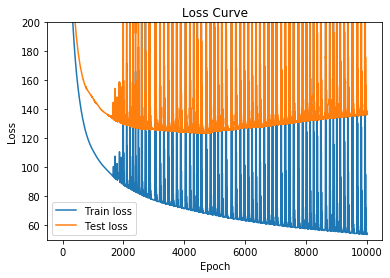

In [115]:
    plt.plot(loss_train, label="Train loss")
    plt.plot(loss_test, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("loss_plot.png", dpi=1000)
    plt.ylim(50, 200)
    plt.show()

In [108]:
pred = model(g, node_features)

In [109]:
pred[5]

tensor([-5.7924], device='cuda:0', grad_fn=<SelectBackward0>)

In [110]:
node_labels[5]

tensor([4.], device='cuda:0')

In [111]:
i=655
print(pred[i])
print(node_labels[i])

tensor([-6.7852], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-19.], device='cuda:0')


In [112]:
# 导入sklearn库中的metrics模块
from sklearn import metrics

# 定义一个函数，根据值是否大于15，将其转化为1或0
def binarize(x):
    if x > 15:
        return 1
    else:
        return 0

# 使用列表推导式，将node_labels和pred中的每个元素都应用binarize函数，得到二值化的列表
node_labels_bin = [binarize(x) for x in node_labels]
pred_bin = [binarize(x) for x in pred]

# 使用metrics模块中的函数，计算准确率、召回率等特征
accuracy = metrics.accuracy_score(node_labels_bin, pred_bin)
precision = metrics.precision_score(node_labels_bin, pred_bin)
recall = metrics.recall_score(node_labels_bin, pred_bin)
f1 = metrics.f1_score(node_labels_bin, pred_bin)

# 打印结果
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")


Accuracy: 0.9334466156896063
Precision: 0.777027027027027
Recall: 0.7172557172557172
F1 score: 0.7459459459459459


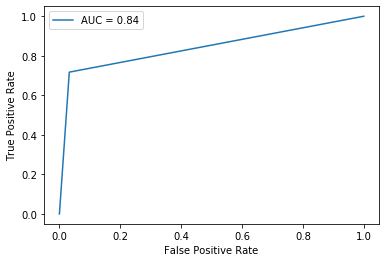

In [113]:
# 导入sklearn库中的metrics模块
from sklearn import metrics

# 使用roc_curve()函数，计算真正率和假正率
fpr, tpr, thresholds = metrics.roc_curve(node_labels_bin, pred_bin)
# 使用auc()函数，计算AUC值
auc = metrics.auc(fpr, tpr)
# 使用matplotlib库，绘制AUC曲线
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
